**多层感知机**

@ Follow: "动手学深度学习-第四章 多层感知机"

In [1]:
import numpy as np
from d2l import torch as d2l
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch import nn
import torchvision
from torchvision import transforms
from IPython import display


dir_data = Path("/Users/rui/Code/Astronote/32_PyTorch/data/chapter4")
dir_data.mkdir(parents=True, exist_ok=True)

In [2]:
def load_data_fashion_mnist(batch_size, resize=None, download=False):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=dir_data, train=True, 
                                                    transform=trans, download=download)
    mnist_test = torchvision.datasets.FashionMNIST(root=dir_data, train=False, 
                                                   transform=trans, download=download)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, 
                                        num_workers=4),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, 
                                        num_workers=4))

In [3]:
class Accumulator:
    """在`n`个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期(定义见第3章)"""
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]


class Animator:
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(5, 3)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型(定义见第3章)"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 1, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc


In [4]:
def predict_ch3(net, test_iter, n=6):
    """预测标签(定义见第3章)"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

# 基本概念
- 多层感知机(Multilayer Perceptron, MLP)是最简单的深度神经网络
- MLP的架构：将许多全连接层堆叠在一起，每一层都输出到其上面的层，直到生成最后的输出
- 在网络中加入一个或多个隐藏层来突破线性模型的限制，使其能够处理更普遍的函数关系
- 直接添加隐藏层相当于对仿射函数做仿射变换，结果还是仿射函数，还是线性模型。因此对仿射变换之后的每个隐藏单元应用非线性的激活函数，使MLP不再退化成线性模型。
- 更深，而不是更广的网络，可以更容易地逼近许多函数

# 常见的激活函数

## 修正线性单元(Recified Linear Unit, ReLU)
- 函数: $\rm ReLU(x) = max(x, 0)$, 即元素和0中的最大值，保留正元素，丢弃所有负元素
- 使用ReLU的原因是它的求导表现特别好: 要么参数消失, 要么参数通过
- 一个ReLU的变体, 参数化ReLU (parameterized ReLU, pReLU): $\rm pReLU(x) = max(0, x) + \alpha min(0, x)$

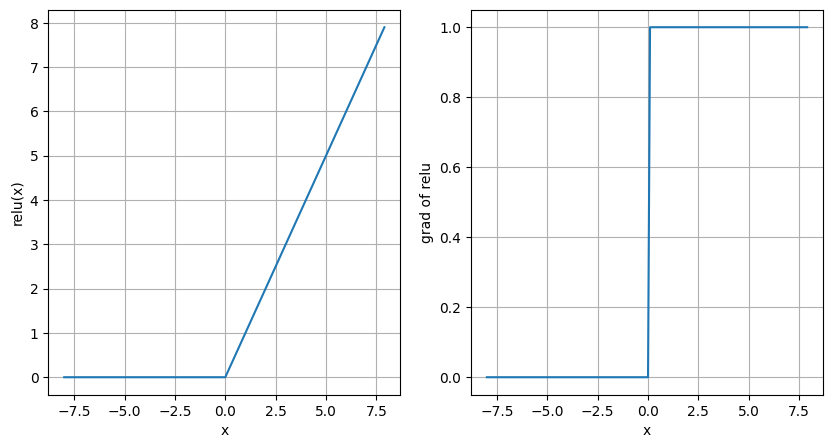

In [5]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
y.backward(torch.ones_like(x), retain_graph=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(x.detach().numpy(), y.detach().numpy())
axes[0].set_xlabel('x')
axes[0].set_ylabel('relu(x)')
axes[0].grid()

axes[1].plot(x.detach().numpy(), x.grad.numpy())
axes[1].set_xlabel('x')
axes[1].set_ylabel('grad of relu')
axes[1].grid()

## Sigmoid函数
- Sigmoid函数也称挤压函数: 它将任意数值压缩到(0, 1)上的某个值
- 函数: $\rm sigmoid(x) = \frac{1}{1 + exp(-x)}$
- Sigmoid函数在隐藏层中较少使用, 大部分时候被更简单的ReLU所取代
- Sigmoid函数的导数: $\rm \frac{d}{dx} sigmoid(x) = sigmoid(x)(1 - sigmoid(x))$

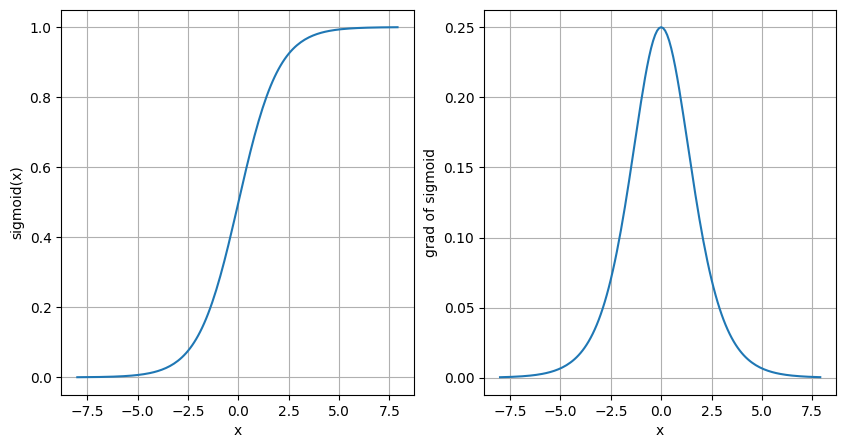

In [6]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x), retain_graph=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(x.detach().numpy(), y.detach().numpy())
axes[0].set_xlabel('x')
axes[0].set_ylabel('sigmoid(x)')
axes[0].grid()

axes[1].plot(x.detach().numpy(), x.grad.numpy())
axes[1].set_xlabel('x')
axes[1].set_ylabel('grad of sigmoid')
axes[1].grid()

## 双曲正切函数(tanh)
- 类似sigmoid函数, 能将任意数值压缩到(-1, 1)区间
- 函数: $\rm tanh(x) = \frac{1-exp(-2x)}{1+exp(-2x)}$
- 导数: $\rm \frac{d}{dx} tanh(x) = 1 - tanh^2(x)$

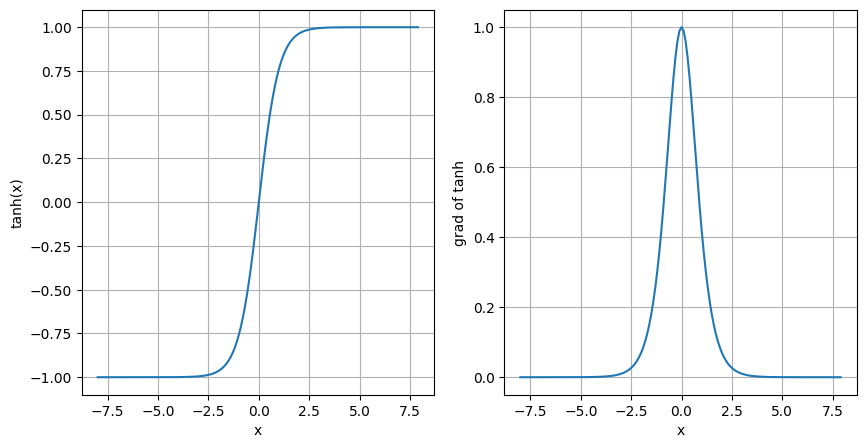

In [7]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.tanh(x)
y.backward(torch.ones_like(x), retain_graph=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(x.detach().numpy(), y.detach().numpy())
axes[0].set_xlabel('x')
axes[0].set_ylabel('tanh(x)')
axes[0].grid()

axes[1].plot(x.detach().numpy(), x.grad.numpy())
axes[1].set_xlabel('x')
axes[1].set_ylabel('grad of tanh')
axes[1].grid()

---
# 多层感知机

In [8]:
# 加载数据集
batch_size = 256

train_iter, test_iter = load_data_fashion_mnist(batch_size, download=False)

## 初始化模型
- 隐藏层宽度一般为2的N次幂, 提高硬件的计算效率

In [9]:
num_inputs = 784  # 输入层宽度为特征数量, 即28 * 28 = 784
num_outputs = 10  # 输出层宽度为类别数量
num_hiddens = 256  # 隐藏层宽度

W1 = nn.Parameter(
    torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01
)
b1 = nn.Parameter(
    torch.zeros(num_hiddens, requires_grad=True)
)
W2 = nn.Parameter(
    torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01
)
b2 = nn.Parameter(
    torch.zeros(num_outputs, requires_grad=True)
)
params = [W1, b1, W2, b2]

## 激活函数

In [10]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## 定义向前传播函数

In [11]:
def net(X):
    X = X.reshape(-1, num_inputs)
    H = relu(X @ W1 + b1)
    return (H @ W2 + b2)

## 损失函数

In [12]:
loss = nn.CrossEntropyLoss(reduction='none')

## 训练

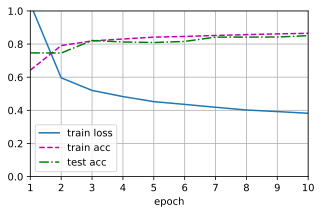

In [13]:
num_epochs, lr = 10, 0.1

updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

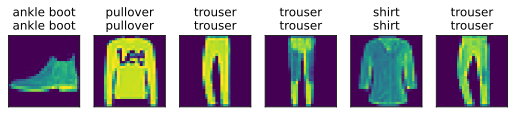

In [14]:
predict_ch3(net, test_iter)

---
# MLP的简洁实现

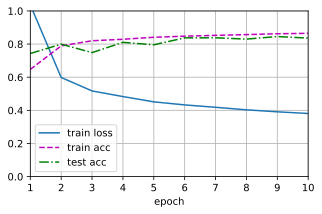

In [15]:
net_new = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net_new.apply(init_weights)

batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net_new.parameters(), lr=lr)

train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch3(net_new, train_iter, test_iter, loss, num_epochs, trainer)

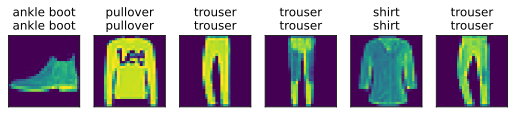

In [16]:
predict_ch3(net_new, test_iter)

---
# 过拟合与欠拟合
- 训练误差: 模型在训练数据集上计算到的误差
- 泛化误差: 模型应用在同样从原始样本的分布中抽取的`无限多数据样本(理想的测试集)`时, 模型误差的期望
- 关于模型复杂性:
    1. 具有较多参数的模型可能被认为更复杂
    2. 具有较大取值范围的模型可能更复杂
    3. 很难比较不同大类的模型(如, 决策树和神经网络)的复杂性
- 关于验证集:
    1. 为确定候选模型(不同超参数)中的最佳模型, 通常会使用验证集
    2. 在确定所有超参数之前, 不要用到测试集
    3. 没有足够多的数据划分验证集时, 可以使用K折交叉验证
- 关于过拟合:
    1. 最好的预测模型在训练数据上的表现往往比验证数据上好的多
    2. 通常更关心验证误差, 而不是训练误差和验证误差之间的差距
    3. 数据量增加, 泛化能力通常会变好

## 生成数据
- 给定x, 生成3阶多项式生成数据
    $$y = 5 + 1.2 x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon$$

In [17]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小

true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

featrues = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(featrues)

poly_features = np.power(featrues, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= np.math.gamma(i + 1)  # `gamma(n)` = (n-1)!

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)  # labels对应y

# NumPy ndarray转换为tensor
true_w, featrues, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, featrues, poly_features, labels]
]

## 定义损失

In [18]:
def evaluate_loss(net, data_iter, loss):
    metric = Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

## 定义训练函数

In [19]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]  # 特征数
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)

    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', 
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (
                evaluate_loss(net, train_iter, loss), 
                evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

## 三阶多项式函数拟合
- 模拟的真值函数就是3阶多项式, 因此3阶是最佳模型

weight: [[ 4.9924684  1.184423  -3.4215074  5.6229486]]
True w: tensor([ 5.0000,  1.2000, -3.4000,  5.6000])


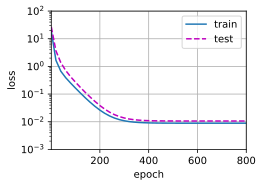

In [20]:
train(
    train_features=poly_features[:n_train, :4],
    test_features=poly_features[n_train:, :4],
    train_labels=labels[:n_train],
    test_labels=labels[n_train:],
    num_epochs=800
)
print(f"True w: {true_w[:4]}")

## 线性函数(欠拟合)

weight: [[3.6097977 3.077598 ]]
True w: tensor([ 5.0000,  1.2000, -3.4000,  5.6000])


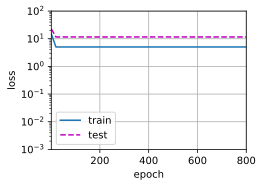

In [21]:
train(
    train_features=poly_features[:n_train, :2],
    test_features=poly_features[n_train:, :2],
    train_labels=labels[:n_train],
    test_labels=labels[n_train:],
    num_epochs=800
)
print(f"True w: {true_w[:4]}")

## 使用高阶多项式(过拟合)

weight: [[ 4.96311569e+00  1.23099709e+00 -3.25111270e+00  5.27446985e+00
  -4.96015012e-01  1.33295894e+00  6.73872530e-02 -1.66859627e-02
   3.95328254e-02 -1.57310084e-01  4.38768836e-03 -1.67823657e-01
   2.39450857e-02 -5.51466718e-02  1.37429908e-01  1.03269786e-01
  -6.57300465e-03 -1.02373511e-02 -1.75097257e-01 -2.18761906e-01]]
True w: tensor([ 5.0000,  1.2000, -3.4000,  5.6000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])


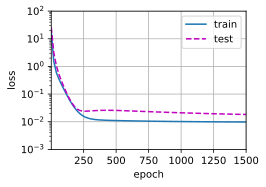

In [22]:
train(
    train_features=poly_features[:n_train, :],
    test_features=poly_features[n_train:, :],
    train_labels=labels[:n_train],
    test_labels=labels[n_train:],
    num_epochs=1500
)
print(f"True w: {true_w[:]}")

---
# 权重衰减
- 正则化技术(缓解过拟合的手段)：
    1. 总是可以通过收集更多的训练数据来缓解过拟合
    2. 权重衰减是最广泛的正则化技术之一
- 权重衰减
    1. 也称L2正则化
    2. 权重向量的范数反映了模型的复杂度
    3. 要保证权重向量较小(低模型复杂度), 方法是将其范数作为惩罚项添加到损失函数中
- 线性回归中的正则化
    1. 添加L1范数正则化线性模型构成经典的岭回归(ridge regression)
    2. 添加L2范数正则化线性模型构成经典的lasso回归(lasso regression)
- 为什么使用L2范数而不是L1范数?
    L2范数对权重分量的大分量施加了巨大惩罚, 容易得到大量特征上均匀分布的模型, 预测误差更稳定
- 使用L2正则化的损失函数:
    $$L(w, b) + \frac{\lambda}{2}||w||^2$$
    其中, $\lambda$为正则化常数, 数值越大, 约束越大; $\lambda = 0$时, 恢复为原来的损失函数

## 生成模拟数据
- 模拟多项式函数: $y = 0.05 + \sum_{i=1}^{d} 0.02x_i + \epsilon$

In [23]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5

true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05

train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)

test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 从0实现

In [24]:
# 随机初始化模型参数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

# L2范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

# 训练函数
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', torch.norm(w).item())

## 无正则化

L2 norm of w: 13.30837631225586


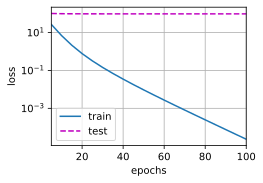

In [25]:
train(lambd=0)

## 使用正则化

L2 norm of w: 0.35106489062309265


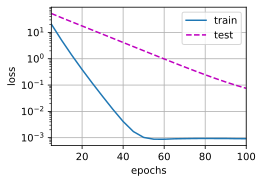

In [26]:
train(lambd=3)

## 简洁实现

In [27]:
def train_concise(lambd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params": net[0].weight, 'weight_decay': lambd},
        {"params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())

L2 norm of w: 13.131180763244629


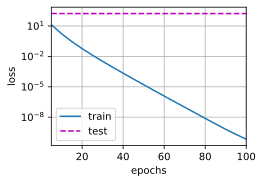

In [28]:
train_concise(lambd=0)

L2 norm of w: 0.41813698410987854


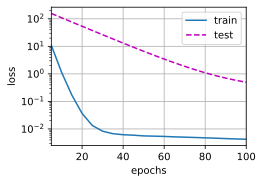

In [29]:
train_concise(lambd=3)

---
# 暂退法(Dropout)
- 在每次训练迭代时，每个神经元都有一定的**概率p(称为保留率）**被保留，而其他神经元则被暂时移除。
- 由于每次训练时的网络结构都不同，模型不会过度依赖某些特定的神经元，能更好地学习数据的整体特征，从而提高泛化能力。
- 测试时，不会进行Dropout，而是使用所有神经元，并将输出按训练时的Dropout比例进行缩放，以保证训练和测试的一致性。

## Dropout函数实现
Dropout需保证期望一致：
$$\rm E(p_i * X^{new}_i) = E(X_i)$$
其中, 
- $X_i$是同一个隐藏层中各个神经元的输入值
- dropout技术随机产生每个元素的保留率$\rm p = (1 - dropout)$

然而, 这样并不能保证Dropout前后的期望相同, 只有在i无穷大时才成立

In [30]:
def dropout_layer(X, dropout):
    """
    dropout为丢弃概率
    """
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [31]:
X = torch.arange(20000, dtype=torch.float32).reshape((2, 10000))
print(X)
print(f"期望: {X.mean(dim=1)}")

tensor([[0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 9.9970e+03, 9.9980e+03,
         9.9990e+03],
        [1.0000e+04, 1.0001e+04, 1.0002e+04,  ..., 1.9997e+04, 1.9998e+04,
         1.9999e+04]])
期望: tensor([ 4999.5000, 14999.4990])


In [32]:
X_new = dropout_layer(X, 0)  # 不丢弃
print(X_new)
print(f"期望: {X_new.mean(dim=1)}")

tensor([[0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 9.9970e+03, 9.9980e+03,
         9.9990e+03],
        [1.0000e+04, 1.0001e+04, 1.0002e+04,  ..., 1.9997e+04, 1.9998e+04,
         1.9999e+04]])
期望: tensor([ 4999.5000, 14999.4990])


In [33]:
X_new = dropout_layer(X, 0.5)  # 丢弃50%
print(X_new)
print(f"期望: {X_new.mean(dim=1)}")

tensor([[    0.,     0.,     0.,  ..., 19994., 19996., 19998.],
        [20000., 20002.,     0.,  ...,     0., 39996., 39998.]])
期望: tensor([ 5046.8330, 15006.6914])


In [34]:
X_new = dropout_layer(X, 0.2)  # 丢弃2%
print(X_new)
print(f"期望: {X_new.mean(dim=1)}")

tensor([[0.0000e+00, 1.2500e+00, 2.5000e+00,  ..., 1.2496e+04, 1.2498e+04,
         1.2499e+04],
        [1.2500e+04, 0.0000e+00, 1.2502e+04,  ..., 2.4996e+04, 2.4998e+04,
         2.4999e+04]])
期望: tensor([ 5011.0713, 15038.2549])


## 从0实现

In [35]:
# 定义模型参数
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

# 定义模型
dropout1 = 0.2
dropout2 = 0.5

# 定义模型
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2, is_training=True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape(-1, self.num_inputs)))
        # 只有在训练模型时才使用dropout
        if self.training:
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, dropout2)
            
        out = self.lin3(H2)
        return out
    
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

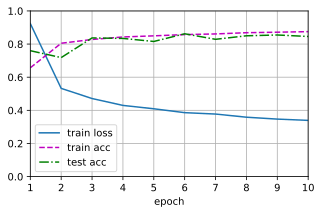

In [36]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 简洁实现

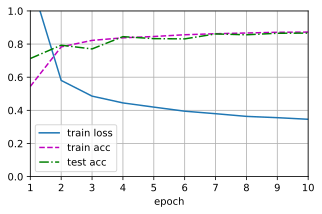

In [37]:
net = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(784, 256),
    nn.ReLU(), 
    # 在第一个全连接层之后添加一个dropout层
    nn.Dropout(dropout1),
    nn.Linear(256, 256),
    nn.ReLU(),
    # 在第二个全连接层之后添加一个dropout层
    nn.Dropout(dropout2),
    nn.Linear(256, 10)
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

---
# 向前传播、反向传播、计算图
- 向前传播(forward propagation): 按顺序(从输入层到输出层)计算和存储神经网络中每层的结果
- 反向传播(backward propagation): 根据微积分中的链式法则计算神经网络参数的梯度的方法
- 训练:
    1. 初始化模型参数后, 交替使用向前传播和反向传播来更新模型参数
    2. 反向传播重复利用向前传播中存储的中间值, 因此需要更多的内存
    3. 内存的需求与网络层数和批量大小大致呈正比

---
# 数值稳定性与模型初始化
- 模型初始化的重要性:
    1. 初始化对数值稳定性至关重要
    2. 决定优化函数的收敛速度
    3. 糟糕的选择会面临梯度消失和梯度爆炸问题
- 梯度消失:
    1. 梯度消失（Vanishing Gradient）是指在深度神经网络中，随着误差反向传播到网络的较早层时，梯度值变得越来越小，最终导致更新的权重几乎为零，从而使得这些层的参数无法有效地更新，影响网络的训练效果。
    2. 梯度消失的原因:
        - 激活函数的选择：一些激活函数，特别是 Sigmoid 和 Tanh，容易导致梯度消失问题。它们的导数在输入值较大或较小时接近零。具体来说：Sigmoid 函数的导数很大或很小时会接近 0。Tanh 函数的导数在输入值非常大或非常小时也趋近于 0。
        - 深度网络结构：在深层网络中，误差通过多层传递时，梯度会逐层传递并乘以每一层的导数。假如每一层的梯度都较小，那么梯度会被不断压缩，导致靠近输入层的梯度变得极其小，甚至消失。
        - 权重初始化不当：如果神经网络的初始权重设置得过小，导致网络输出接近零，可能会使得激活函数的输出接近饱和区，从而产生小梯度。
- 梯度爆炸:
    1. 梯度爆炸（Exploding Gradient）是指在神经网络的训练过程中，梯度在反向传播时变得非常大，导致网络权重更新幅度过大，从而导致不稳定的训练过程。这会导致模型的损失函数值迅速变得非常大，甚至使得网络训练失败，模型无法收敛。
    2. 梯度爆炸的原因
        - 权重初始化不当：如果神经网络的初始权重设置过大，会导致反向传播时计算的梯度值也很大。因为在反向传播过程中，每一层的梯度会乘以该层的权重，如果权重初始化过大，梯度就会逐层放大，导致梯度爆炸。
        - 深度网络结构：在深层网络中，梯度会通过多层的反向传播传播。如果每一层的梯度值较大，那么梯度就会逐层放大，最终导致靠近输入层的梯度变得极大，出现梯度爆炸。
        - 激活函数的选择：某些激活函数（如 ReLU 或其变种）可能在某些情况下导致梯度过大。例如，如果输入值非常大，那么 ReLU 函数的导数为常数1，这可能导致梯度在传递过程中被不断放大。
        - 不适当的学习率：使用过高的学习率会导致权重更新步伐过大，可能会使梯度爆炸。即使在梯度计算正常的情况下，过大的学习率也会导致权重更新过于剧烈，使得训练变得不稳定。